## 學習重點
1. 如何使用python實作聯邦學習的演算法
2. FedAVG的演算法細節
3. FedProx的演算法細節

## 下面是完整的範例程式碼
問題定義
* 實現聯邦學習算法，分別練習客戶端數據集為獨立同分布 (i.i.d.) 或非獨立同分布 (non-iid) 的情況。
* 使用卷積神經網絡和 cifar10 數據集進行實驗。
* 首先以資料完全集中方式訓練網絡，並實現 FedAvg 算法處理 i.i.d. 的客戶端數據集。
* 接著丟棄 i.i.d. 假設，改為以非 i.i.d. 方式切割數據集，並實現 FedProx 算法處理非 i.i.d. 的客戶端數據集。
* 將 FedProx 結果與 FedAvg 結果進行比較，並與所有資料集中訓練的結果進行對比。


ref: 
https://github.com/erfunmirzaei/FedAvg-FedProx

In [1]:
#Importing required libraries 
import numpy as np
import matplotlib.pyplot as plt
import math 
import os, sys 
import random 
import copy
import string

import torch 
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
from typing import Callable, List, Optional, Tuple
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence 
from torch.optim.lr_scheduler import MultiStepLR, StepLR
import torch.optim as optim

from tqdm.notebook import tqdm

In [2]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [3]:
device

device(type='cuda', index=0)

## 簡單的CNN網路結構

In [4]:
class Deep_CNN(nn.Module):
    """
    Implement the network architecture which was used in "Personalized Federated Learning: A Meta-Learning Approach" Paper.
    """
    def __init__(self, num_classes):
        super(Deep_CNN, self).__init__() 

        # First layer
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second layer
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)

        # First Hidden layer 
        self.fc1 = nn.Linear(16 * 5 *5, 120)
        
        # Second Hidden layer
        self.fc2 = nn.Linear(120, 84)
        
        # Classifier 
        self.fc3 = nn.Linear(84,num_classes)

        # Activation Function 
        self.relu = nn.ReLU()     

        # Dropout 
        self.dropout = nn.Dropout( p= 0.2)
           
    
    def forward(self,x):
        # First Layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        # Second Layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = torch.flatten(x, start_dim = 1)

        # First Hidden layer 
        x = self.fc1(x)
        x = self.relu(x)

        # Second Hidden layer
        x = self.fc2(x)
        x = self.relu(x)
   
        # Classifier
        x = self.fc3(x)

        return x


# 集中式訓練方法

## 預處理

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

torch.manual_seed(2045)
max_epochs = 1000
batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


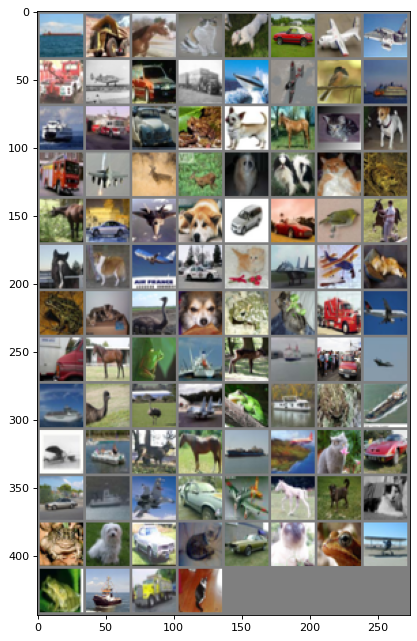

 ship truck horse   cat   dog   car plane plane truck plane   car truck  ship plane  bird  ship  ship truck   car  frog   dog horse   cat   dog truck plane  deer  deer   dog   dog   cat  frog horse   car plane   dog   car   car  bird horse horse   dog plane   car   cat plane plane   cat  frog   cat  bird   dog  frog   cat truck plane truck horse  frog  ship  deer  ship   car plane  ship  bird  bird plane  frog  ship  frog  ship plane  ship  deer horse  ship plane   cat   car   car  ship plane   car plane horse   dog   cat  frog   dog   car   cat   car   cat  frog plane  frog  ship truck   cat


In [6]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 10), dpi=80)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## 合理檢驗(Sanity Check)
確保模型可以在少量資料上實現overfitting，如果損失值無法降為0，則這個資料集下，模型複雜度不夠。需要更換模型。

<img src="https://vitalflux.com/wp-content/uploads/2020/12/overfitting-and-underfitting-wrt-model-error-vs-complexity.png"  width="600" height="300">



ref: https://blog.csdn.net/weixin_44120025/article/details/114668841

In [7]:
# Model 
Net = Deep_CNN(10)
Net.to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr = 0.01, momentum = 0.9)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.99) 

train_losses = []
train_accs = []

validation_losses = []
val_accs = []

dataiter = iter(trainloader)
train_data, train_labels = next(dataiter)

val_dataiter = iter(testloader)
val_data, val_labels = next(val_dataiter)

max_epochs = 1000

# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    # Transfer to GPU
    train_data, train_labels = train_data.to(device), train_labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Model computations
    # forward + backward + optimize
    batch_train_outputs = Net(train_data)

    loss = criterion(batch_train_outputs, train_labels.long())
    loss.backward()
    optimizer.step()
    # scheduler.step()
    # print statistics
    running_trainloss += loss.item()
    running_loss += loss.item()

    train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

    if train_cnt % 100 == 99:    # print every 10 mini-batches
        print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
        running_loss = 0.0
    
    train_cnt += 1
    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False): # with torch.no_grad()
        #for val_data, val_labels in tqdm(validation_generator):
        # Transfer to GPU
        val_data, val_labels = val_data.to(device), val_labels.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(val_data)
        
        val_loss = criterion(batch_outputs, val_labels.long())

        running_valloss += val_loss.item()
        running_loss += val_loss.item()

        val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

        if val_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0

        val_cnt += 1
    
    train_acc = train_acc.cpu()
    val_acc = val_acc.cpu()
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)

  0%|          | 0/1000 [00:00<?, ?it/s]

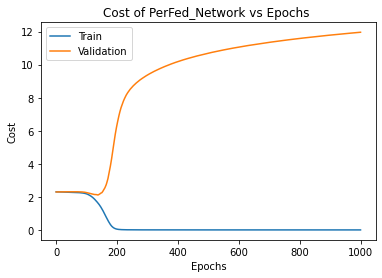

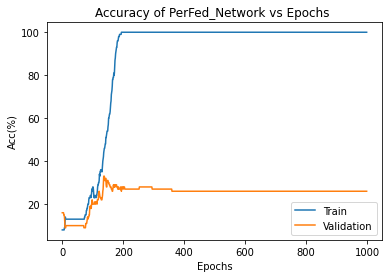

In [8]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of PerFed_Network vs Epochs ")
    plt.ylabel('Cost') # 可以理解成損失就好
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title("Accuracy of PerFed_Network vs Epochs ")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

可以看到我們的Train Cost達到0，Validation的Cost在合理性檢驗其實沒有意義，不需要在意。只要Train Cost達到0，合理性檢驗就能夠通過

## 集中式訓練
我們會做兩次，第一次lr設為0.05，第二次lr設為0.01。比較兩次的差異同時也觀察epoch是否足夠

In [9]:
# Model 
Net = Deep_CNN(10)
Net.to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr = 0.05, momentum = 0.9)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.99) 

train_losses = []
validation_losses = []

train_accs = []
val_accs = []

max_epochs = 10

# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    for train_data, train_labels in tqdm(trainloader):
        # Transfer to GPU
        train_data, train_labels = train_data.to(device), train_labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # Model computations
        # forward + backward + optimize
        batch_train_outputs = Net(train_data)
        # print(batch_train_outputs.shape, train_labels.shape)
        # break
        loss = criterion(batch_train_outputs, train_labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

        if train_cnt % 100 == 99:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 100))
            running_loss = 0.0

        train_cnt += 1
    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for val_data, val_labels in tqdm(testloader):
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net(val_data)
            
            val_loss = criterion(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            if val_cnt % 100 == 99:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 100))
                running_loss = 0.0

            val_cnt += 1
    
    
    train_acc = train_acc.cpu()
    val_acc = val_acc.cpu()
    # scheduler.step()      
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

RuntimeError: DataLoader worker (pid(s) 188524) exited unexpectedly

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of FF Network")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title("Accuracy of FF Network")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

In [ ]:
# Model 
Net2 = Deep_CNN(10)
Net2.to(device)

# Define Loss function and Optimizer
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(Net2.parameters(), lr = 0.01, momentum = 0.9)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.99) 

train_losses2 = []
validation_losses2 = []

train_accs2 = []
val_accs2 = []

max_epochs = 10

# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    for train_data, train_labels in tqdm(trainloader):
        # Transfer to GPU
        train_data, train_labels = train_data.to(device), train_labels.to(device)
        
        # zero the parameter gradients
        optimizer2.zero_grad()

        # Model computations
        # forward + backward + optimize
        batch_train_outputs = Net2(train_data)

        loss = criterion2(batch_train_outputs, train_labels)
        loss.backward()
        optimizer2.step()
        
        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

        if train_cnt % 100 == 99:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 100))
            running_loss = 0.0

        train_cnt += 1
    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for val_data, val_labels in tqdm(testloader):
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net2(val_data)
            
            val_loss = criterion2(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            if val_cnt % 100 == 99:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 100))
                running_loss = 0.0

            val_cnt += 1
    
    train_acc = train_acc.cpu()
    val_acc = val_acc.cpu()
    
    # scheduler.step()      
    train_losses2.append(running_trainloss / train_cnt)
    train_accs2.append(train_acc / train_cnt * 100)
    validation_losses2.append(running_valloss / val_cnt)
    val_accs2.append(val_acc / val_cnt * 100)

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses2)
    plt.plot(validation_losses2)
    plt.title("Cost of Deep CNN")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs2)
    plt.plot(val_accs2)
    plt.title("Accuracy of Deep CNN")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

可以看到兩次的訓練，validation的曲線都還在向上，表示epoch還可以繼續增加。但我們的模型已經能在CIFAR10上有不錯的表現。

Let’s quickly save our trained model:

In [ ]:
PATH = 'PerFed_Net.pth'
torch.save(Net.state_dict(), PATH)

# Federated Learning (IID)
在獨立同分布下進行聯邦學習

## 均勻的切分資料分給不同客戶端


In [ ]:
transform2 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

torch.manual_seed(2045)

batch_size2 = 50

trainset2 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform2)

testset2 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform2)

testloader2 = torch.utils.data.DataLoader(testset2, batch_size=batch_size2,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

n = 100 # 客戶端的數量
N = len(trainset2.__dict__['targets']) # 實際上Cifar10總共有幾筆資料
N_prime = len(testset2.__dict__['targets']) 
print('N =', N, 'N_prime =',N_prime )
n_i = N // n
n_i_prime = N_prime // n
print('n_i =', n_i, 'n_i_prime =',n_i_prime )

train_sets2 = []
test_sets2 = []
# trainset2會下去迭代，每一次執行random_split，trainset2就會被均勻的切一片下來。就像切吐司機每轉一圈就有一片切下來
for i in range(n):
    subset1, trainset2 = random_split(trainset2, (n_i ,N - n_i))
    train_sets2.append(subset1)
    N = N - n_i 

    subset2, testset2 = random_split(testset2, (n_i_prime ,N_prime - n_i_prime))
    test_sets2.append(subset2)
    N_prime = N_prime - n_i_prime 

train_loaders2 = [torch.utils.data.DataLoader(train_sets2[i], batch_size=batch_size2, # batchsize 50, n_i = 500，所以一個dataloader有10個batch
                                          shuffle=True, num_workers=2) for i in range(n)]  # 1個list，裡面包含所有切分出來的dataset形成的dataloader


test_loaders2 = [torch.utils.data.DataLoader(test_sets2[i], batch_size=batch_size2,
                                          shuffle=True, num_workers=2) for i in range(n)] # 同上，測試用的。1個list，裡面包含所有切分出來的dataset形成的dataloader

In [ ]:
labels = []
for train_data, train_labels in train_loaders2[9]:
    labels.append(train_labels)

In [ ]:
labels

In [ ]:
# 證明均勻抽樣
tmp = torch.zeros(torch.bincount(labels[0]).shape)
for i in labels:

    tmp += torch.bincount(i)
tmp

## FedAVG演算法
非常普通常見的torch train_step

```
中心伺服器
加權平均權重
使用C參數對客戶端抽樣，避免資料多的客戶端完全主導權重(會導致variance提高)
使用個別資料數量作為聚合的加權
```
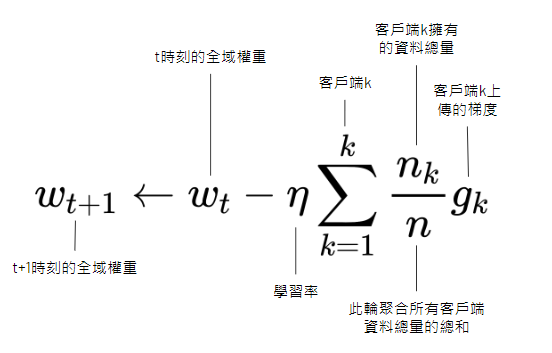

In [19]:
class FedAvg_ClientUpdate(object):


    def __init__(self, train_loader):

        self.train_loader =  train_loader
        # Define Loss function
        self.criterion = nn.CrossEntropyLoss()

    def update(self, net, max_epochs, lr):   
        optimizer = optim.SGD(net.parameters(), lr = lr, momentum = 0.9)           
        
        train_losses = []
        validation_losses = []

        train_accs = []
        val_accs = []

        # Loop over epochs
        for epoch in range(max_epochs):
            
            running_trainloss, train_acc = 0.0, 0.0
            train_cnt = 0

            # Training
            for train_data, train_labels in self.train_loader:
                # Transfer to GPU
                train_data, train_labels = train_data.to(device), train_labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # Model computations
                # forward + backward + optimize
                batch_train_outputs = net(train_data)

                loss = self.criterion(batch_train_outputs, train_labels)
                loss.backward()
                optimizer.step()
                
                # print statistics
                running_trainloss += loss.item()

                train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

                train_cnt += 1
           
            train_losses.append(running_trainloss / train_cnt)
            train_accs.append(train_acc / train_cnt )

        return net.state_dict(), sum(train_losses) / len(train_losses), sum(train_accs) / len(train_accs) 

    def FedAvg(self, w_dict, w_prime_dict, coeff):
        for k in w_dict.keys():
            w_dict[k] = w_dict[k] + coeff * w_prime_dict[k]
        return w_dict

## FedAvg 訓練 
要注意的是round的設計，聯邦學習作為分散式學習的一種，會需要進行許多round(輪)的訓練。
FedAVG要注意的是
1. 伺服器端指定局域端的超參數(B, E, lr)
2. C參數決定哪一些客戶端在這一輪參與(隨機抽樣)

另外這裡也要請同學熟悉torch如何操作參數
```
# 拿參數
net.state_dict()
```
參數以字典形式表示，其中的元素是鍵值配對，鍵是layer.name; 值是torch.Tensor可以進行計算。(相對的，Tensorflow透過get_layer在這裡會拿到list)


In [19]:
# Model 
Net3 = Deep_CNN(10)
Net3.to(device)

# # Define Loss function and Optimizer
criterion3 = nn.CrossEntropyLoss()

train_losses3 = []
validation_losses3 = []

train_accs3 = []
val_accs3 = []

max_rounds = 100
C = 0.1
E = 5
learning_rate = 0.01
w_dict = copy.deepcopy(Net3.state_dict())

# Loop over epochs
for round in tqdm(range(max_rounds)):
    running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    clients = random.sample(list(np.arange(n)), k = int(C * n))
    coeffs = [ 1 / len(clients) for i in range(n)]

    for k in w_dict.keys():
        w_dict[k] = torch.zeros_like(w_dict[k])
    
    # Training
    for i in clients:
        cl_upd = FedAvg_ClientUpdate(train_loaders2[i])
        w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(Net3).to(device), E, learning_rate)
        w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i])
        print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))      
        running_trainloss += train_loss
        train_acc += acc
        train_cnt += 1

    Net3.load_state_dict(w_dict)
    # print("******", Net3.state_dict()['fc1.bias'])

    val_acc = 0
    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader2:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net3(val_data)
            
            val_loss = criterion3(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            val_cnt += 1

    # learning_rate = learning_rate * 0.99        
    print("-"*10)
    print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
    print("Cost of Validation data for in round %i: %f" %(round + 1, running_valloss / val_cnt))
    print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100)) 
    print("Acc of Validation data for in round %i: %f" %(round + 1, val_acc / val_cnt * 100))  
    print("-"*10)
    
    train_acc = train_acc.cpu()
    val_acc = val_acc.cpu()
    train_losses3.append(running_trainloss / train_cnt)
    train_accs3.append(train_acc / train_cnt * 100)
    validation_losses3.append(running_valloss / val_cnt)
    val_accs3.append(val_acc / val_cnt * 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Train data for client 68 in round 1 for 5 epochs: 2.300372
Cost of Train data for client 54 in round 1 for 5 epochs: 2.301232
Cost of Train data for client 61 in round 1 for 5 epochs: 2.302031
Cost of Train data for client 79 in round 1 for 5 epochs: 2.297817
Cost of Train data for client 45 in round 1 for 5 epochs: 2.299260
Cost of Train data for client 72 in round 1 for 5 epochs: 2.298029
Cost of Train data for client 15 in round 1 for 5 epochs: 2.298244
Cost of Train data for client 33 in round 1 for 5 epochs: 2.300140
Cost of Train data for client 43 in round 1 for 5 epochs: 2.297640
Cost of Train data for client 20 in round 1 for 5 epochs: 2.300306
----------
Cost of Train data for in round 1: 2.299507
Cost of Validation data for in round 1: 2.298129
Acc of Train data for in round 1: 11.732000
Acc of Validation data for in round 1: 13.250009
----------
Cost of Train data for client 84 in round 2 for 5 epochs: 2.287150
Cost of Train data for client 87 in round 2 for 5 epoch

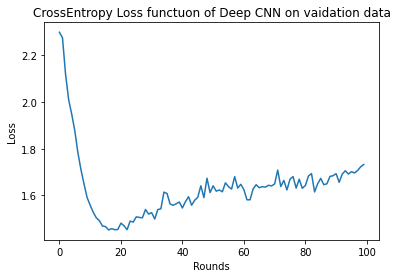

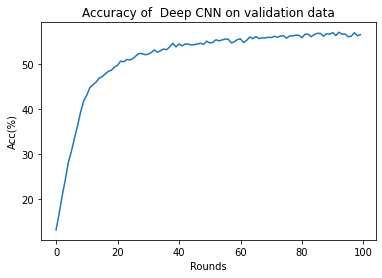

In [20]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    # plt.plot(train_losses3)
    plt.plot(validation_losses3)
    plt.title("CrossEntropy Loss functuon of Deep CNN on vaidation data")
    plt.ylabel('Loss')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    # plt.plot(train_accs3)
    plt.plot(val_accs3)
    plt.title("Accuracy of  Deep CNN on validation data")
    plt.ylabel('Acc(%)')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

In [21]:
PATH = 'Fed_Primal_1.pth'
torch.save(Net3.state_dict(), PATH)

單純的做第二次，但學習率從0.01增加到0.02。

In [ ]:
# Model 
Net4 = Deep_CNN(10)
Net4.to(device)

# # Define Loss function and Optimizer
criterion4 = nn.CrossEntropyLoss()

train_losses4 = []
validation_losses4 = []

train_accs4 = []
val_accs4 = []

max_rounds = 100
C = 0.1
E = 5
learning_rate = 0.02
w_dict = copy.deepcopy(Net4.state_dict())

# Loop over epochs
for round in tqdm(range(max_rounds)):
    running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    clients = random.sample(list(np.arange(n)), k = int(C * n))
    coeffs = [ 1 / len(clients) for i in range(n)]

    for k in w_dict.keys():
        w_dict[k] = torch.zeros_like(w_dict[k])
    
    # Training
    for i in clients:
        cl_upd = FedAvg_ClientUpdate(train_loaders2[i])
        w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(Net4).to(device), E, learning_rate)
        w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i])
        print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))      
        running_trainloss += train_loss
        train_acc += acc
        train_cnt += 1

    Net4.load_state_dict(w_dict)
    # print("******", Net3.state_dict()['fc1.bias'])

    val_acc = 0
    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader2:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net4(val_data)
            
            val_loss = criterion4(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            val_cnt += 1

    # learning_rate = learning_rate * 0.99        
    print("-"*10)
    print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
    print("Cost of Validation data for in round %i: %f" %(round + 1, running_valloss / val_cnt))
    print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100)) 
    print("Acc of Validation data for in round %i: %f" %(round + 1, val_acc / val_cnt * 100))  
    print("-"*10)
    
    train_acc = train_acc.cpu()
    val_acc = val_acc.cpu()
    
    train_losses4.append(running_trainloss / train_cnt)
    train_accs4.append(train_acc / train_cnt * 100)
    validation_losses4.append(running_valloss / val_cnt)
    val_accs4.append(val_acc / val_cnt * 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Train data for client 52 in round 1 for 5 epochs: 2.295048
Cost of Train data for client 24 in round 1 for 5 epochs: 2.299249
Cost of Train data for client 32 in round 1 for 5 epochs: 2.297679
Cost of Train data for client 73 in round 1 for 5 epochs: 2.299905
Cost of Train data for client 34 in round 1 for 5 epochs: 2.296875
Cost of Train data for client 29 in round 1 for 5 epochs: 2.298985
Cost of Train data for client 9 in round 1 for 5 epochs: 2.287251
Cost of Train data for client 31 in round 1 for 5 epochs: 2.294909
Cost of Train data for client 1 in round 1 for 5 epochs: 2.297215
Cost of Train data for client 11 in round 1 for 5 epochs: 2.298143
----------
Cost of Train data for in round 1: 2.296526
Cost of Validation data for in round 1: 2.296551
Acc of Train data for in round 1: 11.487999
Acc of Validation data for in round 1: 14.600006
----------
Cost of Train data for client 26 in round 2 for 5 epochs: 2.255868
Cost of Train data for client 9 in round 2 for 5 epochs: 

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/opt/conda/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 328, in reduce_storage
    fd, size = storage._share_fd_()
RuntimeError: falseINTERNAL ASSERT FAILED at "/opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/MapAllocator.cpp":300, please report a bug to PyTorch. unable to write to file </torch_188366_9>


In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    # plt.plot(train_losses3)
    plt.plot(validation_losses4)
    plt.title("CrossEntropy Loss functuon of Deep CNN on vaidation data")
    plt.ylabel('Loss')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    # plt.plot(train_accs3)
    plt.plot(val_accs4)
    plt.title("Accuracy of  Deep CNN on validation data")
    plt.ylabel('Acc(%)')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

In [ ]:
PATH = 'Fed_Primal_2.pth'
torch.save(Net4.state_dict(), PATH)

# Federated Learning (Non-IID Dataset)
在非獨立同分布下進行聯邦學習

## 不均勻的切分資料分給不同客戶端

In [7]:
class Cifar10(torch.utils.data.Dataset):
    
    def __init__(self, train_set, list_IDs):
        self.train_set = train_set
        self.list_IDs = list_IDs
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)
    
    def __getitem__(self,index):
        ind = self.list_IDs[index]
        return self.train_set[ind]

In [8]:
def cifar_noniid(dataset, num_users,  batch_size):
    """
    Sample non-I.I.D client data from CIFAR10 dataset
    將
    :param dataset:
    :param num_users:
    :return:
    """
    n = num_users
    n_i = len(dataset) // n // 2 # each class items per client 
    cifar_labels = { i: [] for i in range(10) } 
    
    
    # cifar_labels: key = 0~9 as cifar10 labels; value: 對應於label為key值的資料index
    for i in range(len(dataset)):
        cifar_labels[dataset[i][1]].append(i) # [dataset[0][1]] 相當於該「筆」資料的label
    
    
    # 將字典中的每個標籤分割成數個大小相等的子集，每個子集包含相同數量的標籤。
    for i in range(10):
        cifar_labels[i] = [cifar_labels[i][x:x+n_i] for x in range(0, len(cifar_labels[i]), n_i)]
    
    '''
    函數將這些子集分配給指定數量的用戶。對於每個用戶，函數從每個標籤的子集中選擇一個子集，
    並將其中的所有資料索引合併在一起，最終返回一個包含每個用戶對應的子集的 PyTorch DataLoader 列表。
    '''
    users_dict = dict()
    i = 0
    for user in range(n):
        if len(cifar_labels[i]) > 0:    
            users_dict[user] = cifar_labels[i][0] + cifar_labels[i+1][0]
            del cifar_labels[i][0]
            del cifar_labels[i+1][0]
        
        else :
            i = i + 2
            users_dict[user] = cifar_labels[i][0] + cifar_labels[i+1][0]
            del cifar_labels[i][0]
            del cifar_labels[i+1][0]

    train_loaders = [torch.utils.data.DataLoader(Cifar10(dataset,users_dict[i]), batch_size=batch_size,shuffle=True, num_workers = 2) for i in range(n)] 
    
    return train_loaders

In [9]:
transform3 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

torch.manual_seed(2045)
n = 100
batch_size3 = 50

trainset3 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform3)

trainloader3 = torch.utils.data.DataLoader(trainset3, batch_size=batch_size3,
                                          shuffle= True, num_workers=1)

testset3 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform3)

testloader3 = torch.utils.data.DataLoader(testset3, batch_size=batch_size3,
                                         shuffle=False, num_workers=1)

train_loaders3 = cifar_noniid(trainset3, n, batch_size3)



Files already downloaded and verified
Files already downloaded and verified


In [15]:
labels = []

for train_data, train_labels in train_loaders3[80]:
    labels.append(train_labels)
labels

[tensor([8, 9, 8, 9, 9, 8, 8, 8, 9, 8, 9, 9, 9, 9, 8, 8, 9, 9, 9, 8, 8, 9, 9, 9,
         9, 8, 9, 8, 9, 9, 8, 8, 9, 8, 8, 9, 8, 9, 8, 9, 9, 9, 8, 8, 8, 8, 8, 9,
         8, 8]),
 tensor([9, 8, 8, 9, 8, 8, 8, 8, 8, 8, 8, 9, 8, 8, 9, 8, 9, 8, 9, 9, 8, 8, 8, 9,
         8, 8, 8, 9, 9, 8, 8, 8, 8, 9, 9, 8, 8, 9, 8, 8, 9, 8, 9, 9, 9, 8, 8, 9,
         9, 9]),
 tensor([8, 8, 9, 9, 8, 8, 8, 8, 9, 8, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 8,
         8, 8, 9, 8, 9, 8, 9, 8, 9, 9, 8, 8, 9, 9, 8, 9, 8, 9, 8, 9, 9, 9, 8, 9,
         8, 9]),
 tensor([8, 8, 9, 9, 8, 8, 8, 9, 9, 9, 8, 8, 8, 8, 8, 9, 9, 8, 9, 8, 8, 9, 8, 9,
         9, 8, 8, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 9, 9, 9, 8, 8, 9, 9, 9, 9, 8,
         9, 8]),
 tensor([8, 9, 8, 9, 8, 8, 9, 8, 9, 9, 9, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8, 8, 8, 9,
         8, 9, 8, 8, 8, 9, 9, 9, 8, 9, 9, 8, 9, 9, 9, 9, 9, 8, 8, 9, 8, 9, 8, 9,
         8, 9]),
 tensor([9, 9, 8, 8, 9, 9, 9, 9, 9, 9, 8, 9, 9, 8, 8, 9, 9, 9, 8, 9, 8, 9, 9, 9,
         8, 9, 9, 8, 9, 

In [16]:
# 證明Non-IID抽樣，每個client都只有兩個類別了
tmp = torch.zeros(torch.bincount(labels[0]).shape)
for i in labels:
    tmp += torch.bincount(i)
tmp

tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 250., 250.])

## FedProx 演算法
跟FedAVG的差別在於loss的計算。

```
中心伺服器
限制客戶端權重本身的變化量，提高每一輪聚合的效率，並降低資料異質性的影響
根據local權重與Global權重的2-norm給予懲罰
基本上跟FedAVG相同，重點在於調整客戶端訓練的損失函數。

FedProx對損失函數的調整在於限制客戶端權重本身的變化量，當某些客戶端在本地過擬合的時候，FedProx會減少過擬合的影響，藉此降低變異數，同時也解決聚合時因為個別客戶端過擬合而導致權重難以收斂的問題。
```

![](http://cumatrixfile.cupoy.com/00000185C411041B000000026375706F795F72656C656173654355/1677743525597/large)

ref: https://pytorch.org/docs/stable/generated/torch.norm.html

In [17]:
class FedProx_ClientUpdate(object):
    
    def __init__(self, train_loader):

        self.train_loader =  train_loader
        
        # Define Loss function
        self.criterion = nn.CrossEntropyLoss()
    
    # FedProx的設計
    def loss_function(self, net, w_t, batch_train_outputs, train_labels, mu):
        w_dict = net.state_dict()
        loss1 = self.criterion(batch_train_outputs, train_labels)

        loss2 = 0
        for l in w_dict.keys():
            loss2 += torch.norm(w_dict[l].float() - w_t[l].float(), p = 2) 
        
        return loss1 + (mu /2) * loss2

    def update(self, net, max_epochs, lr, mu):
        optimizer = optim.SGD(net.parameters(), lr = lr, momentum = 0.9)           
        w_t = copy.deepcopy(net.state_dict())

        train_losses = []
        validation_losses = []

        train_accs = []
        val_accs = []

        # Loop over epochs
        for epoch in range(max_epochs):
            
            running_trainloss,  train_acc = 0.0, 0.0
            train_cnt = 0

            # Training
            for train_data, train_labels in self.train_loader:
                # Transfer to GPU
                train_data, train_labels = train_data.to(device), train_labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # Model computations
                # forward + backward + optimize
                batch_train_outputs = net(train_data)

                loss = self.loss_function(net, w_t, batch_train_outputs, train_labels, mu)
                loss.backward()
                optimizer.step()
                
                # print statistics
                running_trainloss += loss.item()

                train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

                train_cnt += 1
           
            train_losses.append(running_trainloss / train_cnt)
            train_accs.append(train_acc / train_cnt )

        return net.state_dict(), sum(train_losses) / len(train_losses), sum(train_accs)/len(train_accs) 

    def FedAvg(self, w_dict, w_prime_dict, coeff):
        for k in w_dict.keys():
            w_dict[k] = w_dict[k] + coeff * w_prime_dict[k]
        return w_dict

## Non-IID Training
非獨立同分布的情境

### FedAvg 訓練

In [22]:
# Model 
Net6 =  Deep_CNN(10)
Net6.to(device)

# Define Loss function and Optimizer
criterion6 = nn.CrossEntropyLoss()

train_losses6 = []
validation_losses6 = []

train_accs6 = []
val_accs6 = []

max_rounds = 100
C = 0.1
E = 5
learning_rate = 0.01
w_dict = copy.deepcopy(Net6.state_dict())

# Loop over epochs
for round in tqdm(range(max_rounds)):
    running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    clients = random.sample(list(np.arange(n)), k = int(C * n))
    coeffs = [ 1 / len(clients) for i in range(n)]

    for k in w_dict.keys():
        w_dict[k] = torch.zeros_like(w_dict[k])
    
    # Training
    for i in clients:
        cl_upd = FedAvg_ClientUpdate(train_loaders3[i])
        w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(Net6).to(device), E, learning_rate)
        w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i])
        print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))      
        running_trainloss += train_loss
        train_acc += acc
        train_cnt += 1

    Net6.load_state_dict(w_dict)

    val_acc = 0
    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader3:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net6(val_data)
            
            val_loss = criterion6(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            val_cnt += 1

    # learning_rate = learning_rate * 0.99        
    print("-"*10)
    print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
    print("Cost of Validation data for in round %i: %f" %(round + 1, running_valloss / val_cnt))
    print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100)) 
    print("Acc of Validation data for in round %i: %f" %(round + 1, val_acc / val_cnt * 100))  
    print("-"*10)
    
    train_acc = train_acc.cpu()
    val_acc = val_acc.cpu()
    
    train_losses6.append(running_trainloss / train_cnt)
    train_accs6.append(train_acc / train_cnt * 100)
    validation_losses6.append(running_valloss / val_cnt)
    val_accs6.append(val_acc / val_cnt * 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Train data for client 1 in round 1 for 5 epochs: 1.351260
Cost of Train data for client 26 in round 1 for 5 epochs: 1.396608
Cost of Train data for client 17 in round 1 for 5 epochs: 1.362535
Cost of Train data for client 23 in round 1 for 5 epochs: 1.325388
Cost of Train data for client 32 in round 1 for 5 epochs: 1.314692
Cost of Train data for client 91 in round 1 for 5 epochs: 1.213827
Cost of Train data for client 44 in round 1 for 5 epochs: 1.379629
Cost of Train data for client 19 in round 1 for 5 epochs: 1.344829
Cost of Train data for client 39 in round 1 for 5 epochs: 1.336492
Cost of Train data for client 65 in round 1 for 5 epochs: 1.526486
----------
Cost of Train data for in round 1: 1.355174
Cost of Validation data for in round 1: 2.463989
Acc of Train data for in round 1: 51.436008
Acc of Validation data for in round 1: 10.000010
----------
Cost of Train data for client 99 in round 2 for 5 epochs: 0.946598
Cost of Train data for client 54 in round 2 for 5 epochs

ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

RuntimeError: DataLoader worker (pid(s) 229224) exited unexpectedly

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    # plt.plot(train_losses3)
    plt.plot(validation_losses6)
    plt.title("CrossEntropy Loss functuon of Deep CNN on vaidation data")
    plt.ylabel('Loss')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    # plt.plot(train_accs3)
    plt.plot(val_accs6)
    plt.title("Accuracy of  Deep CNN on validation data")
    plt.ylabel('Acc(%)')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

In [ ]:
PATH = 'Fed_Non_IID_1.pth'
torch.save(Net6.state_dict(), PATH)

### FedProx 訓練

In [ ]:
# Model 
Net5 =  Deep_CNN(10)
Net5.to(device)

# Define Loss function and Optimizer
criterion5 = nn.CrossEntropyLoss()

train_losses5 = []
validation_losses5 = []

train_accs5 = []
val_accs5 = []

max_rounds = 50
C = 0.1
E = 5
mu = 3
learning_rate = 0.01
w_dict = copy.deepcopy(Net5.state_dict())

# Loop over epochs
for round in tqdm(range(max_rounds)):
    running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    clients = random.sample(list(np.arange(n)), k = int(C * n))
    coeffs = [ 1 / len(clients) for i in range(n)]

    for k in w_dict.keys():
        w_dict[k] = torch.zeros_like(w_dict[k])
    
    # Training
    for i in clients:
        cl_upd = FedProx_ClientUpdate(train_loaders3[i])
        w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(Net5).to(device), E, learning_rate, mu)
        w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i]) # 聚合
        print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))      
        running_trainloss += train_loss
        train_acc += acc
        train_cnt += 1

    Net5.load_state_dict(w_dict)

    val_acc = 0
    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader3:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net5(val_data)
            
            val_loss = criterion5(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            val_cnt += 1

    # learning_rate = learning_rate * 0.99        
    print("-"*10)
    print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
    print("Cost of Validation data for in round %i: %f" %(round + 1, running_valloss / val_cnt))
    print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100)) 
    print("Acc of Validation data for in round %i: %f" %(round + 1, val_acc / val_cnt * 100))  
    print("-"*10)
    train_losses5.append(running_trainloss / train_cnt)
    train_accs5.append(train_acc / train_cnt * 100)
    validation_losses5.append(running_valloss / val_cnt)
    val_accs5.append(val_acc / val_cnt * 100)

In [ ]:

# # Loop over epochs
# for round in tqdm(range(max_rounds)):
#     running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
#     train_cnt, val_cnt = 0, 0
#     clients = random.sample(list(np.arange(n)), k = int(C * n))
#     coeffs = [ 1 / len(clients) for i in range(n)]

#     for k in w_dict.keys():
#         w_dict[k] = torch.zeros_like(w_dict[k])
    
#     # Training
#     for i in clients:
#         cl_upd = FedProx_ClientUpdate(train_loaders3[i])
#         w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(Net5).to(device), E, learning_rate, mu)
#         w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i])
#         print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))      
#         running_trainloss += train_loss
#         train_acc += acc
#         train_cnt += 1

#     Net5.load_state_dict(w_dict)

#     val_acc = 0
#     with torch.set_grad_enabled(False):
#         for val_data, val_labels in testloader3:
#             # Transfer to GPU
#             val_data, val_labels = val_data.to(device), val_labels.to(device)
            
#             # Model computations
#             # forward + backward + optimize
#             batch_outputs = Net5(val_data)
            
#             val_loss = criterion5(batch_outputs, val_labels.long())

#             running_valloss += val_loss.item()

#             val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

#             val_cnt += 1

#     # learning_rate = learning_rate * 0.99        
#     print("-"*10)
#     print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
#     print("Cost of Validation data for in round %i: %f" %(round + 1, running_valloss / val_cnt))
#     print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100)) 
#     print("Acc of Validation data for in round %i: %f" %(round + 1, val_acc / val_cnt * 100))  
#     print("-"*10)
    
#     train_acc = train_acc.cpu()
#     val_acc = val_acc.cpu()
    
#     train_losses5.append(running_trainloss / train_cnt)
#     train_accs5.append(train_acc / train_cnt * 100)
#     validation_losses5.append(running_valloss / val_cnt)
#     val_accs5.append(val_acc / val_cnt * 100)

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    # plt.plot(train_losses3)
    plt.plot(validation_losses5)
    plt.title("CrossEntropy Loss functuon of Deep CNN on vaidation data")
    plt.ylabel('Loss')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    # plt.plot(train_accs3)
    plt.plot(val_accs5)
    plt.title("Accuracy of  Deep CNN on validation data")
    plt.ylabel('Acc(%)')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

In [ ]:
PATH = 'Fed_Non_IID_2.pth'
torch.save(Net5.state_dict(), PATH)